In [3]:
# !pip install gekko
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import json

In [4]:
def print_results(history):
    """
    A function for results printing
    """
    name = history['name']
    print(f'Results for {name}')
    check = lambda x: 'x' in x and x != 'x_final'
    x_keys = [(item[0], float(item[1][-1])) for item in history.items() if check(item[0])]
    for key, x in x_keys:
        print(f'{key}: {x:.4f}')
    obj = history['obj_final']
    print(f'Objective {obj:.4f}')

Suppose we have 

* $z \in \mathbb{R}^{n_z}$ - continuous variable
* $y \in \mathbb{R}^{n_y}$ - integer variable

So we have **Mixed-Integer Non Linear Programming** problem:

$
\min\limits_{y, z}{F(y, z)}, \quad
\left\{ \begin{array}{l}
G(y, z) = 0 \\
H(y, z) \leq 0 \\
y \in P \\
y \in \mathbb{Z}^{n_y}
\end{array} \right.
\;\; $ and 
$
\;\; F(y, z) = \frac{1}{2} \|F_1(y, z)\|_2^2 + F_2(y, z)
$

**Proposal three-step algorithm**:

$
J_{NLP}(y) = \min\limits_{z}{F(y, z)}, \quad
\left\{ \begin{array}{l}
G(y, z) = 0 \\
H(y, z) \leq 0 \\
\end{array} \right.
$

**S1**:
$
(y^*, z^*) = \arg\min\limits_{y}{J_{NLP}(y)}, \quad
y \in P
$

**S2**:
$
y^{**} = \arg\min\limits_{y}{d(y, y^*)}, \quad
y \in P \cup Z^{n_y}
$

**S3**:
$
z^{***} = \arg J_{NLP}(y^{**}) = \arg\min\limits_{z}{F(y^{**}, z)}, \quad
\left\{ \begin{array}{l}
G(y, z) = 0 \\
H(y, z) \leq 0 \\
\end{array} \right.
$

$d(y, y^*) = \|y - y^*\|$

**Example**:

* $x_1, x_2$ - continuous 
* $x_3, x_4$ - integer
* $(x_1, x_2, x_3, x_4)_0 = (1, 5, 5, 1)$

$
\min\limits_{x_1, x_2, x_3, x_4}{x_1 x_4 (x_1 + x_2 + x_3) + x_3}, \quad
\left\{ \begin{array}{l}
x_1^2 + x_2^2 + x_3^2 + x_4^2 = 40 \\
x_1 x_2 x_3 x_4 \geq 25 \\
1 \leq x_1, x_2, x_3, x_4 \leq 5 \\
x_3, x_4 \in \mathbb{Z}
\end{array} \right.
$

It means that:

$F(\overbrace{x_1, x_2}^{z}, \overbrace{x_3, x_4}^{y}) = x_1 x_4 (x_1 + x_2 + x_3) + x_3 $

$G(x_1, x_2, x_3, x_4) = x_1^2 + x_2^2 + x_3^2 + x_4^2 - 40 $

$H(x_1, x_2, x_3, x_4) = 25 - x_1 x_2 x_3 x_4 $

$P = \{x_1, x_2, x_3, x_4 \mid 1 \leq x_1, x_2, x_3, x_4 \leq 5 \}$

Let solve this by an existing MINLP-solver from GEKKO

In [4]:
# Constraints: equality 
def G(x1, x2, x3, x4):
    return x1 ** 2 + x2 ** 2 + x3 ** 2 + x4 ** 2 - 40

# Constraints: inequality
def H(x1, x2, x3, x4):
    return 25 - x1 * x2 * x3 * x4

# Nonlinear least squares term F1
def F1(x1, x2, x3, x4):
    return x1 ** 2 + (x2 - 5) ** 2

# Nonlinear term F2
def F2(x1, x2, x3, x4):
    return 0

# Objective function
def F(x1, x2, x3, x4):
    return F1(x1, x2, x3, x4) + F2(x1, x2, x3, x4)

In [5]:
def run(x, G, H, F, integer=False, const=False, name=''):
    
    history = {f'x{i}' : [] for i in range(1, 5)}
    history['obj'] = []

    max_iter = 0
    while True:
        m = GEKKO(remote=False)                  # Initialize gekko
        m.options.SOLVER = 1 if integer else 3   # Define the solver

#         # optional solver settings with APOPT
#         m.solver_options = [
#             'minlp_maximum_iterations 500',   # minlp maximum iterations
#             'minlp_max_iter_with_int_sol 10', # minlp iterations with integer solution
#             'minlp_as_nlp 0',                 # treat minlp as nlp 
#             'nlp_maximum_iterations 50',      # nlp sub-problem max iterations
#             'minlp_branch_method 1',          # 1 = depth first, 2 = breadth first
#             'minlp_integer_tol 0.05',         # maximum deviation from whole number
#             'minlp_gap_tol 0.01'              # covergence tolerance
#         ]

        # Continuous variables
        x1 = m.Var(value=x[0], lb=1, ub=5)
        x2 = m.Var(value=x[1], lb=1, ub=5)

        # Integer variables
        x3 = m.Const(value=x[2]) if const else m.Var(value=x[2], lb=1, ub=5, integer=integer)
        x4 = m.Const(value=x[3]) if const else m.Var(value=x[3], lb=1, ub=5, integer=integer)

        # Equations
        m.Equation(G(x1, x2, x3, x4) == 0) # G function
        m.Equation(H(x1, x2, x3, x4) <= 0) # H function

        # Objective
        m.Obj(F(x1, x2, x3, x4))

        m.options.MAX_ITER = max_iter
        m.solve(disp=False,debug=0)

        history['x1'].append(np.array(x1.value))
        history['x2'].append(np.array(x2.value))
        history['x3'].append(np.array(x3.value))
        history['x4'].append(np.array(x4.value))
        history['obj'].append(m.options.OBJFCNVAL)

        if m.options.APPSTATUS==1:
            break
        else:
            max_iter += 1

    x = []
    for key in history.keys():
        history[key] = np.ravel(history[key])
        x.append(history[key][-1])
    history['x_final'] = x[:-1]
    history['obj_final'] = x[-1]
    history['name'] = name

    return history

In [6]:
history_minlp = run((1, 5, 5, 1), G, H, F, True, False, 'MINLP')
print_results(history_minlp)

Results for MINLP
x1: 1.0000
x2: 4.5826
x3: 3.0000
x4: 3.0000
Objective 1.1742


Now we divide the solving into steps:

**S1** : solve the relaxed corresponding problem
$
(y^*, z^*) = \arg\min\limits_{y}{J_{NLP}(y)}, \quad
y \in P
$

In [7]:
history_nlp = run((1, 5, 5, 1), G, H, F, False, False, 'NLP')
print_results(history_nlp)

Results for NLP
x1: 1.0000
x2: 5.0000
x3: 3.4495
x4: 1.4495
Objective 1.0000


**S2**: approximate our continuous solution by an integer one

$
y^{**} = \arg\min\limits_{y}{d(y, y^*)}, \quad
y \in P \cup Z^{n_y}
$

**Gauss-Newton**:

$d(y, y^*) = J_{GN}(y \mid y^*, z^*) - J_{NLP}(y^*)$, where

$J_{GN}(y \mid y^*, z^*) = J_{QP}(y \mid y^*, z^*, B_{GN}(y^*, z^*))$, where 

$
J_{QP}(y \mid y^*, z^*, B) =
\min\limits_{z}{F_{QP}(y, z \mid y^*, z^*, B)}, \quad
\left\{ \begin{array}{l}
G_L(y, z \mid y^*, z^*) = 0 \\
H_L(y, z \mid y^*, z^*) \leq 0 \\
\end{array} \right.
$ where

* $
    B_{GN}(y^*, z^*) = 
    \frac{\partial F_1}{\partial (y, z)}(y^*, z^*)
    (\frac{\partial F_1}{\partial (y, z)}(y^*, z^*))^T
  $

* $
    F_{QP}(y, z \mid y^*, z^*, B) = 
    F_L(y, z \mid y^*, z^*) + 
    \frac{1}{2} 
    \begin{bmatrix} y - y^* \\ z - z^* \end{bmatrix}^T
    B
    \begin{bmatrix} y - y^* \\ z - z^* \end{bmatrix}
  $
* $
   F_{L}(y, z \mid y^*, z^*) = 
   F(y^*, z^*) + \frac{\partial F}{\partial (y, z)}(y^*, z^*)
   ((y, z) - (y^*, z^*))
  $
* $
   G_{L}(y, z \mid y^*, z^*) = 
   G(y^*, z^*) + \frac{\partial G}{\partial (y, z)}(y^*, z^*)
   ((y, z) - (y^*, z^*))
  $
* $
   H_{L}(y, z \mid y^*, z^*) = 
   H(y^*, z^*) + \frac{\partial H}{\partial (y, z)}(y^*, z^*)
   ((y, z) - (y^*, z^*))
  $

In [8]:
# Linearization of the function f
def linear(f, x, x0):
    f_ = lambda x: f(*x)
    f_grad = optimize.approx_fprime(x0, f_, 1e-6)
    delta = (np.array(x) - np.array(x0))
    return f_(x0) + f_grad @ delta

# Quadratization of the function f
def quadratic(f, x, x0, B):
    f_linear = linear(f, x, x0)
    delta = (np.array(x) - np.array(x0))
    return f_linear + 0.5 * delta.T @ B @ delta

# Gaussian-Newton Hessian approximation 
def b_gn(f, x, x0):
    f_ = lambda x: f(*x)
    f_grad = optimize.approx_fprime(x0, f_, 1e-6)
    return np.outer(f_grad, f_grad)

# Positive semidefinition checking 
def pos_semidef(B):
    return np.all(np.linalg.eigvals(B) >= 0)

# Gauss-Newton method
def gauss_newton(f, f1, x, x0):
    B_GN = b_gn(f1, x, x0)
    print(f'Pos.semidef.: {pos_semidef(B_GN)}')
    return quadratic(f, x, x0, B_GN)

In [9]:
x_nlp = history_nlp['x_final']
obj_nlp = history_nlp['obj_final']

G_L = lambda *x: linear(G, x, x_nlp)
H_L = lambda *x: linear(H, x, x_nlp)
F_QP = lambda *x: gauss_newton(F, F1, x, x_nlp)
F_GN = lambda *x: F_QP(x) - obj_nlp

history_dist = run(x_nlp, G_L, H_L, F_QP, True, False, 'DIST')
print_results(history_dist)

Pos.semidef.: True
Pos.semidef.: True
Results for DIST
x1: 1.0000
x2: 4.4606
x3: 4.0000
x4: 2.0000
Objective 1.0000


**S3**: find the corresponding $z$

$
z^{***} = \arg J_{NLP}(y^{**}) = \arg\min\limits_{z}{F(y^{**}, z)}, \quad
\left\{ \begin{array}{l}
G(y, z) = 0 \\
H(y, z) \leq 0 \\
\end{array} \right.
$

In [10]:
x_dist = history_dist['x_final']

history_miqp = run(x_dist, G, H, F, True, True, 'MIQP')
print_results(history_miqp)

Results for MIQP
x1: 1.0000
x2: 4.3589
x3: 4.0000
x4: 2.0000
Objective 1.4110


Measure the results - the minlp solution and the corresponding miqp solution:

In [11]:
obj_minlp = history_minlp['obj_final']
obj_miqp = history_miqp['obj_final']
diff = obj_minlp - obj_miqp
sign = 'positive' if diff > 0 else 'negative'
resl = 'better' if diff > 0 else 'worse'

print(f'MIQP  solution: {obj_minlp:.5f}')
print(f'MINLP solution: {obj_miqp:.5f}')
print(f'Difference: {diff:.5f} - {sign} => MIQP is {resl} than MINLP')

MIQP  solution: 1.17424
MINLP solution: 1.41101
Difference: -0.23677 - negative => MIQP is worse than MINLP


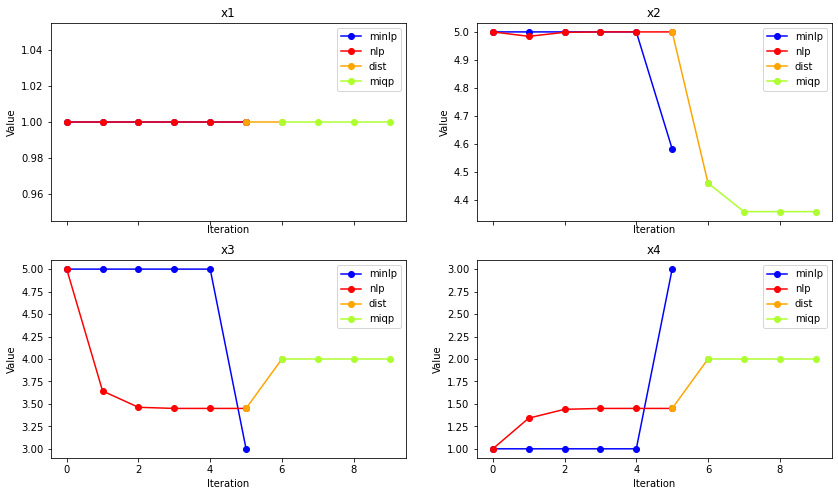

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

for i in range(4):
    xi = f'x{i+1}'
    a, b = i // 2, i % 2
    axes[a][b].set_title(xi)
    axes[a][b].set_xlabel('Iteration')
    axes[a][b].set_ylabel('Value')
    
    x_dist = len(history_nlp[xi]) - 1 + np.arange(len(history_dist[xi]))
    x_miqp = x_dist[-1] + np.arange(len(history_miqp[xi]))

    axes[a][b].plot(history_minlp[xi], '-o', c='blue', label='minlp')
    axes[a][b].plot(history_nlp[xi], '-o', c='red', label='nlp')
    axes[a][b].plot(x_dist, history_dist[xi], '-o', c='orange', label='dist')
    axes[a][b].plot(x_miqp, history_miqp[xi], '-o', c='greenyellow', label='miqp')
    
    axes[a][b].legend()
    
plt.show()

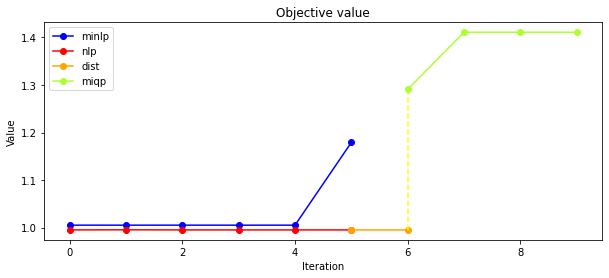

In [26]:
plt.figure(figsize=(10, 4))
plt.title('Objective value')
plt.xlabel('Iteration')
plt.ylabel('Value')
    
x_dist = len(history_nlp['obj']) - 1 + np.arange(len(history_dist['obj']))
x_miqp = x_dist[-1] + np.arange(len(history_miqp['obj']))

plt.plot(np.array(history_minlp['obj'])+0.005, '-o', c='blue', label='minlp')
plt.plot(np.array(history_nlp['obj'])-0.005, '-o', c='red', label='nlp')
plt.plot(x_dist, history_dist['obj']-0.005, '-o', c='orange', label='dist')
plt.vlines(x_dist[-1], 
           history_dist['obj'][-1]-0.005, history_miqp['obj'][0], 
           linestyles='--', color='yellow')
plt.plot(x_miqp, history_miqp['obj'], '-o', c='greenyellow', label='miqp')
    
plt.legend()
    
plt.show()